7524
Class Distribution in Test Set:
Occupancy_Category
Unoccupied    1053
Low            408
High            44
Name: count, dtype: int64
Overall Metrics for Random Forest Classifier:
Accuracy: 0.9535
Precision (Overall): 0.9530
Recall (Overall): 0.9535
F1-Score (Overall): 0.9523


Metrics for Unoccupied:
Precision: 0.9846
Recall: 0.9744
F1-Score: 0.9795
Accuracy: 0.9744


Metrics for Low:
Precision: 0.8915
Recall: 0.9461
F1-Score: 0.9180
Accuracy: 0.9461


Metrics for High:
Precision: 0.7667
Recall: 0.5227
F1-Score: 0.6216
Accuracy: 0.5227




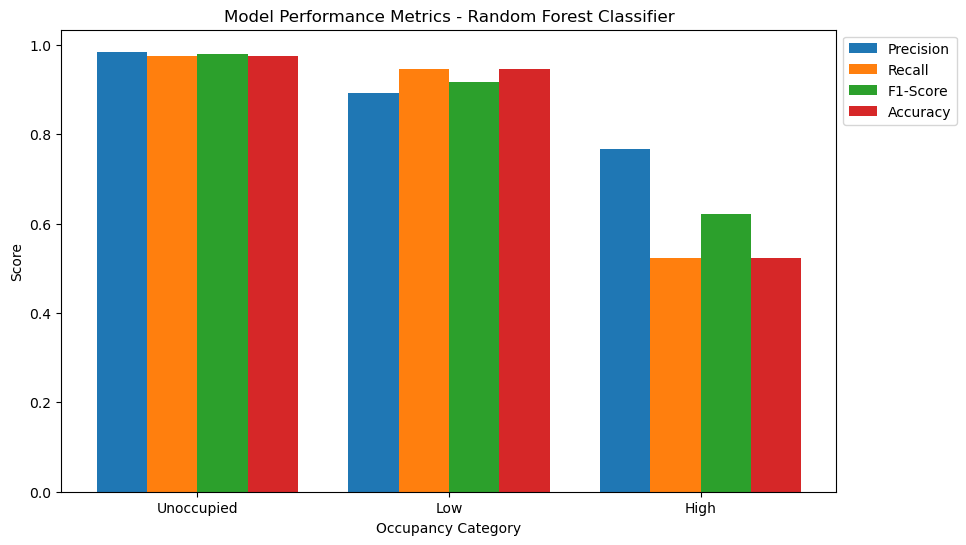

<Figure size 800x600 with 0 Axes>

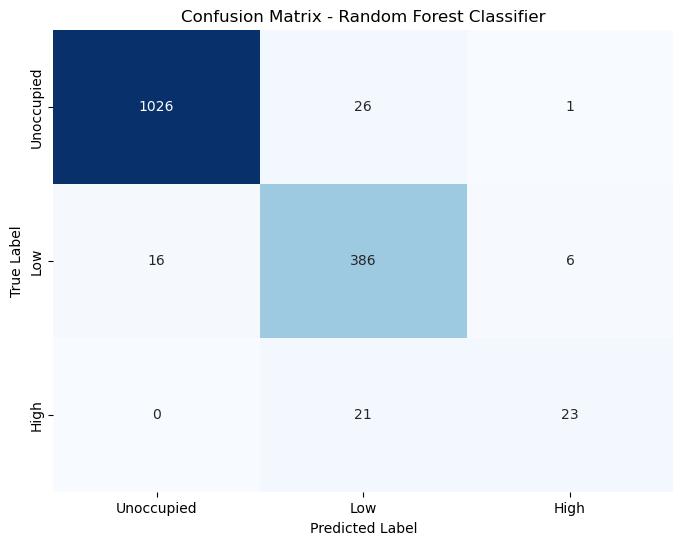

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

        High       0.77      0.52      0.62        44
         Low       0.89      0.95      0.92       408
  Unoccupied       0.98      0.97      0.98      1053

    accuracy                           0.95      1505
   macro avg       0.88      0.81      0.84      1505
weighted avg       0.95      0.95      0.95      1505

The total number of trees in the Random Forest model: 100




In [1]:
#Training a classifier, Unoccupied , low, high occupancy Dartford

#With Scatter Plot and saving the model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Load your data from 'data.csv'
df = pd.read_csv('Dartford/final_combined_560B_7885_data_Dart_21st_Nov.csv', delimiter=",")

# Drop useless columns
drop_columns = ['MOVEMENT_ONBOARD_min', 'MOVEMENT_ONBOARD_max', 'MOVEMENT_ONBOARD_avg']
df = df.drop(columns=drop_columns)
print(len(df))
# Convert 'Datetime' column to datetime format with dayfirst=True
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the rate of change for the specified columns
rate_interest = ['VOC_ONBOARD_last', 'VOC_ONBOARD_min', 'VOC_ONBOARD_max', 'VOC_ONBOARD_avg',
                 'TEMP_SS_1_avg', 'TEMP_SS_1_max','TEMP_SS_1_min','TEMP_SS_1_last','CO2_SS_1_avg', 'TEMP_ONBOARD_avg', 'TEMP_ONBOARD_max','TEMP_ONBOARD_min','TEMP_ONBOARD_last', 'CO2_SS_1_min', 'CO2_SS_1_max', 'CO2_SS_1_last', 'DBC_ONBOARD_max', 'DBC_ONBOARD_min', 'DBC_ONBOARD_avg', 'DBC_ONBOARD_last']
df[rate_interest] = df[rate_interest].replace(',', '.', regex=True).astype(float)

#for column in rate_interest:
    #df[f'{column}_rate'] = df[column].diff() / (df['Datetime'] - df['Datetime'].shift(1)).dt.total_seconds()
# Remove rows with any empty values
#df.dropna(inplace=True)

df['CO2_range'] = df['CO2_SS_1_max'] - df['CO2_SS_1_min']
df['VOC_range'] = df['VOC_ONBOARD_max'] - df['VOC_ONBOARD_min']

#Convert string columns to numeric
df['DBA_ONBOARD_max'] = pd.to_numeric(df['DBA_ONBOARD_max'], errors='coerce')
df['DBA_ONBOARD_min'] = pd.to_numeric(df['DBA_ONBOARD_min'], errors='coerce')
df['DBA_ONBOARD_avg'] = pd.to_numeric(df['DBA_ONBOARD_avg'], errors='coerce')
df['DBA_ONBOARD_last'] = pd.to_numeric(df['DBA_ONBOARD_last'], errors='coerce')
df['TEMP_ONBOARD_max'] = pd.to_numeric(df['TEMP_ONBOARD_max'], errors='coerce')
df['TEMP_ONBOARD_min'] = pd.to_numeric(df['TEMP_ONBOARD_min'], errors='coerce')
df['TEMP_ONBOARD_avg'] = pd.to_numeric(df['TEMP_ONBOARD_avg'], errors='coerce')
df['TEMP_ONBOARD_last'] = pd.to_numeric(df['TEMP_ONBOARD_last'], errors='coerce')
df['TEMP_SS_1_max'] = pd.to_numeric(df['TEMP_SS_1_max'], errors='coerce')
df['TEMP_SS_1_min'] = pd.to_numeric(df['TEMP_SS_1_min'], errors='coerce')
df['TEMP_SS_1_avg'] = pd.to_numeric(df['TEMP_SS_1_avg'], errors='coerce')
df['TEMP_SS_1_last'] = pd.to_numeric(df['TEMP_SS_1_last'], errors='coerce')

df['DBC_range'] = df['DBC_ONBOARD_max'] - df['DBC_ONBOARD_min']
df['temp_onboard_range'] = df['TEMP_ONBOARD_max'] - df['TEMP_ONBOARD_min']
df['temp_SS_1_range'] = df['TEMP_SS_1_max'] - df['TEMP_SS_1_min']
df['CO2_outlier'] = df['CO2_SS_1_avg'] - df['CO2_SS_1_max']
df['VOC_outlier'] = df['VOC_ONBOARD_avg'] - df['VOC_ONBOARD_max']
df['DBA_outlier'] = df['DBA_ONBOARD_avg'] - df['DBA_ONBOARD_max']

# Calculate the 20-minute moving average for VOC, CO2, and temperature
df['VOC_20min_avg'] = df['VOC_ONBOARD_last'].rolling(window=20).mean()
df['CO2_20min_avg'] = df['CO2_SS_1_last'].rolling(window=20).mean()
df['TEMP_20min_avg'] = df['TEMP_ONBOARD_last'].rolling(window=20).mean()


# Fill NaN values with 0 or any other appropriate value
df['VOC_20min_avg'].fillna(0, inplace=True)
df['CO2_20min_avg'].fillna(0, inplace=True)
df['TEMP_20min_avg'].fillna(0, inplace=True)

#Subtract the last known value from the 20 minute moving average
df['VOC_anomaly']= df['VOC_20min_avg']-df['VOC_ONBOARD_max']
df['CO2_anomaly']= df['CO2_20min_avg']-df['CO2_SS_1_max']
df['TEMP_anomaly']=df['TEMP_20min_avg']-df['TEMP_ONBOARD_max']

feature_sets = [

     ['VOC_ONBOARD_last', 'DBC_ONBOARD_last','CO2_SS_1_last', 'MOVEMENT_ONBOARD_last', 'VOC_range','CO2_range', 'DBC_range']
]

for feature_columns in feature_sets:
    # Replace commas (,) with periods (.) in feature columns and convert to float
    df[feature_columns] = df[feature_columns].replace(',', '.', regex=True).astype(float)
    # Specify the target column
    target_column = 'VOC_ONBOARD_Inferred Occupancy'
    df['Occupancy_Category'] = pd.cut(df[target_column], bins=[-np.inf, 0,2, float('inf')], labels=[ 'Unoccupied', 'Low', 'High'])
    # Split the data into features (X) and target (y)
    X = df[feature_columns]
    X_scaled = df[feature_columns]
    y = df['Occupancy_Category']
    class_names = df['Occupancy_Category'].unique()
    # Split the data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, train_size=0.8, random_state=42, stratify=y)
    
    # Check the distribution of classes in the test set
    class_distribution_test = y_test.value_counts()
    print("Class Distribution in Test Set:")
    print(class_distribution_test)
    
    # Create and train the models
    models = [
        #('Random Forest Classifier', RandomForestClassifier(random_state=42))
        ('Random Forest Classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
       
    ]

    for model_name, model in models:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate classification report
        class_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

        # Calculate overall metrics
        overall_accuracy = accuracy_score(y_test, y_pred)
        overall_precision = precision_score(y_test, y_pred, average='weighted')
        overall_recall = recall_score(y_test, y_pred, average='weighted')
        overall_f1 = f1_score(y_test, y_pred, average='weighted')

        # Print overall metrics
        print(f"Overall Metrics for {model_name}:")
        print(f"Accuracy: {overall_accuracy:.4f}")
        print(f"Precision (Overall): {overall_precision:.4f}")
        print(f"Recall (Overall): {overall_recall:.4f}")
        print(f"F1-Score (Overall): {overall_f1:.4f}")
        print("\n")

        # Calculate precision, recall, and f1-score for each class
        precision_values = precision_score(y_test, y_pred, average=None, labels=class_names)
        recall_values = recall_score(y_test, y_pred, average=None, labels=class_names)
        f1_values = f1_score(y_test, y_pred, average=None, labels=class_names)
        
        # Calculate accuracy for each class
        accuracy_values = [accuracy_score(y_test[y_test == class_name], y_pred[y_test == class_name]) for class_name in class_names]
        # Print metrics for each class
        for class_name, precision, recall, f1, accuracy in zip(class_names, precision_values, recall_values, f1_values, accuracy_values):
            print(f"Metrics for {class_name}:")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print("\n")

        # Plot bar chart
        class_order = ['Unoccupied', 'Low', 'High']
        index = np.arange(len(class_order))
        plt.figure(figsize=(10, 6))
        bar_width = 0.2
        index = np.arange(len(class_order))

        # Function to get index for a label in the original class_names
        def get_index(label):
            return class_names.tolist().index(label)

        plt.bar(index, [precision_values[get_index(label)] for label in class_order], bar_width, label='Precision')
        plt.bar(index + bar_width, [recall_values[get_index(label)] for label in class_order], bar_width, label='Recall')
        plt.bar(index + 2 * bar_width, [f1_values[get_index(label)] for label in class_order], bar_width, label='F1-Score')
        plt.bar(index + 3 * bar_width, [accuracy_values[get_index(label)] for label in class_order], bar_width, label='Accuracy')

        plt.xlabel('Occupancy Category')
        plt.ylabel('Score')
        plt.title(f'Model Performance Metrics - {model_name}')
        plt.xticks(index + 1.5 * bar_width, class_order)
        # Add the legend outside the plot
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.savefig('figures/performance_dart_multi_Class_CO2_PIR_DBC_VOC_last_range.png')
        plt.show()

    
        # Specify class labels for the confusion matrix
        class_labels = model.classes_

        # Create a confusion matrix
        confusion = confusion_matrix(y_test, y_pred)

        # Create a confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        class_order = ['Unoccupied', 'Low', 'High']  # Specify the desired order

        # Rearrange the confusion matrix rows
        class_indices = [model.classes_.tolist().index(label) for label in class_order]
        rearranged_confusion = confusion[class_indices, :][:, class_indices]

        # Create a confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(rearranged_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_order, yticklabels=class_order)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('figures/confusion_dart_multi_Class_CO2_PIR_DBC_VOC_last_range.png')
        plt.show()
        # Calculate classification report
        class_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

        # Print the classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred, target_names=model.classes_))

        # Assuming the 'model' is the trained RandomForestClassifier
        tree_in_forest = model.estimators_[0]  # Accessing the first tree from the Random Forest

        # Assuming 'model' is your trained RandomForestClassifier
        total_trees = model.n_estimators
        print(f"The total number of trees in the Random Forest model: {total_trees}")
        
        from joblib import dump
        # Uncomment if you want to save the model
        #dump(model, 'Model/RF_classifier_co2_range_pir_low_high.joblib')
        print("\n")



7524
Class Distribution in Test Set:
Occupancy_Category
Unoccupied    1053
Low            408
High            44
Name: count, dtype: int64
Overall Metrics for Random Forest Classifier:
Accuracy: 0.9535
Precision (Overall): 0.9530
Recall (Overall): 0.9535
F1-Score (Overall): 0.9523


Metrics for Unoccupied:
Precision: 0.9846
Recall: 0.9744
F1-Score: 0.9795
Accuracy: 0.9744


Metrics for Low:
Precision: 0.8915
Recall: 0.9461
F1-Score: 0.9180
Accuracy: 0.9461


Metrics for High:
Precision: 0.7667
Recall: 0.5227
F1-Score: 0.6216
Accuracy: 0.5227




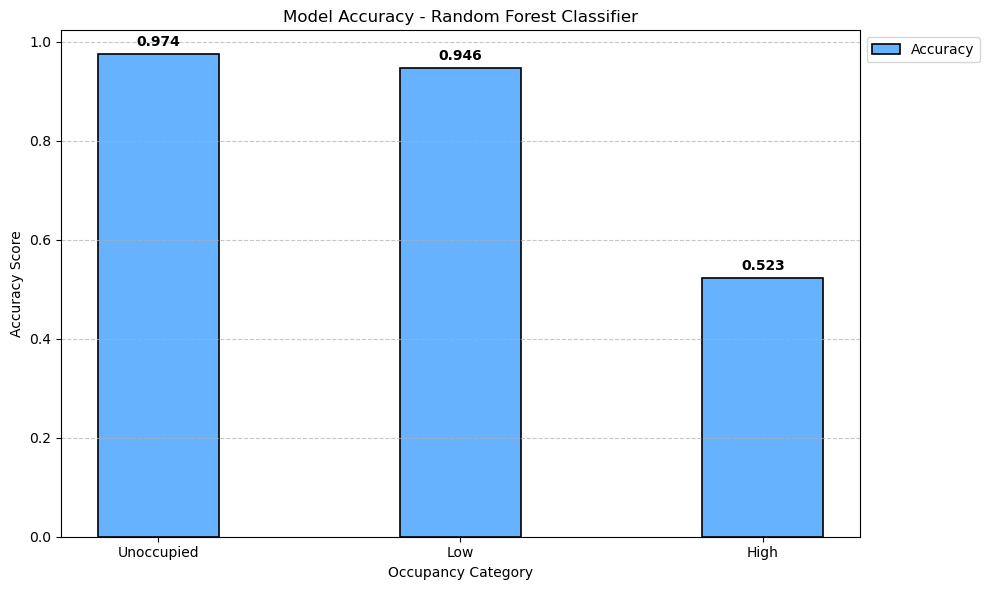

<Figure size 800x600 with 0 Axes>

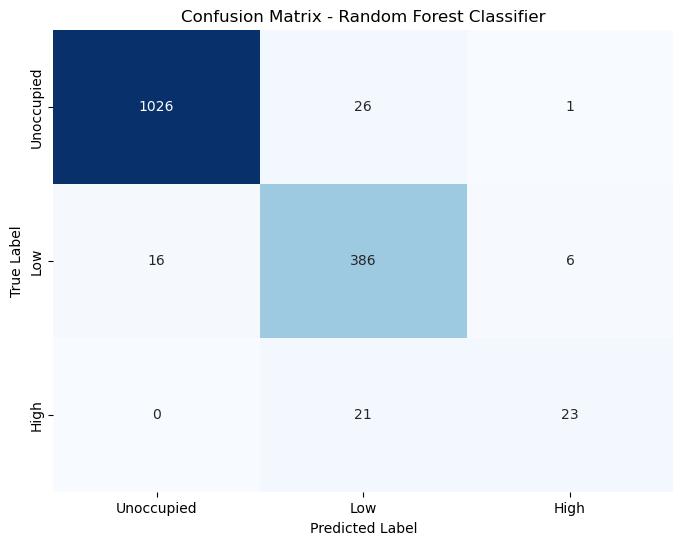

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

        High       0.77      0.52      0.62        44
         Low       0.89      0.95      0.92       408
  Unoccupied       0.98      0.97      0.98      1053

    accuracy                           0.95      1505
   macro avg       0.88      0.81      0.84      1505
weighted avg       0.95      0.95      0.95      1505

The total number of trees in the Random Forest model: 100




In [2]:
#Training a classifier, o , low, high occupancy Dartford
#Same code as above just styling changes
#With Scatter Plot and saving the model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Load your data from 'data.csv'
df = pd.read_csv('Dartford/final_combined_560B_7885_data_Dart_21st_Nov.csv', delimiter=",")

# Drop useless columns
drop_columns = ['MOVEMENT_ONBOARD_min', 'MOVEMENT_ONBOARD_max', 'MOVEMENT_ONBOARD_avg']
df = df.drop(columns=drop_columns)
print(len(df))
# Convert 'Datetime' column to datetime format with dayfirst=True
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the rate of change for the specified columns
rate_interest = ['VOC_ONBOARD_last', 'VOC_ONBOARD_min', 'VOC_ONBOARD_max', 'VOC_ONBOARD_avg',
                 'TEMP_SS_1_avg', 'TEMP_SS_1_max','TEMP_SS_1_min','TEMP_SS_1_last','CO2_SS_1_avg', 'TEMP_ONBOARD_avg', 'TEMP_ONBOARD_max','TEMP_ONBOARD_min','TEMP_ONBOARD_last', 'CO2_SS_1_min', 'CO2_SS_1_max', 'CO2_SS_1_last', 'DBC_ONBOARD_max', 'DBC_ONBOARD_min', 'DBC_ONBOARD_avg', 'DBC_ONBOARD_last']
df[rate_interest] = df[rate_interest].replace(',', '.', regex=True).astype(float)
#for column in rate_interest:
    #df[f'{column}_rate'] = df[column].diff() / (df['Datetime'] - df['Datetime'].shift(1)).dt.total_seconds()

# Remove rows with any empty values
#df.dropna(inplace=True)

df['CO2_range'] = df['CO2_SS_1_max'] - df['CO2_SS_1_min']
df['VOC_range'] = df['VOC_ONBOARD_max'] - df['VOC_ONBOARD_min']

#Convert string columns to numeric
df['DBA_ONBOARD_max'] = pd.to_numeric(df['DBA_ONBOARD_max'], errors='coerce')
df['DBA_ONBOARD_min'] = pd.to_numeric(df['DBA_ONBOARD_min'], errors='coerce')
df['DBA_ONBOARD_avg'] = pd.to_numeric(df['DBA_ONBOARD_avg'], errors='coerce')
df['DBA_ONBOARD_last'] = pd.to_numeric(df['DBA_ONBOARD_last'], errors='coerce')
df['TEMP_ONBOARD_max'] = pd.to_numeric(df['TEMP_ONBOARD_max'], errors='coerce')
df['TEMP_ONBOARD_min'] = pd.to_numeric(df['TEMP_ONBOARD_min'], errors='coerce')
df['TEMP_ONBOARD_avg'] = pd.to_numeric(df['TEMP_ONBOARD_avg'], errors='coerce')
df['TEMP_ONBOARD_last'] = pd.to_numeric(df['TEMP_ONBOARD_last'], errors='coerce')
df['TEMP_SS_1_max'] = pd.to_numeric(df['TEMP_SS_1_max'], errors='coerce')
df['TEMP_SS_1_min'] = pd.to_numeric(df['TEMP_SS_1_min'], errors='coerce')
df['TEMP_SS_1_avg'] = pd.to_numeric(df['TEMP_SS_1_avg'], errors='coerce')
df['TEMP_SS_1_last'] = pd.to_numeric(df['TEMP_SS_1_last'], errors='coerce')

df['DBC_range'] = df['DBC_ONBOARD_max'] - df['DBC_ONBOARD_min']
df['temp_onboard_range'] = df['TEMP_ONBOARD_max'] - df['TEMP_ONBOARD_min']
df['temp_SS_1_range'] = df['TEMP_SS_1_max'] - df['TEMP_SS_1_min']
df['CO2_outlier'] = df['CO2_SS_1_avg'] - df['CO2_SS_1_max']
df['VOC_outlier'] = df['VOC_ONBOARD_avg'] - df['VOC_ONBOARD_max']
df['DBA_outlier'] = df['DBA_ONBOARD_avg'] - df['DBA_ONBOARD_max']

# Calculate the 20-minute moving average for VOC, CO2, and temperature
df['VOC_20min_avg'] = df['VOC_ONBOARD_last'].rolling(window=20).mean()
df['CO2_20min_avg'] = df['CO2_SS_1_last'].rolling(window=20).mean()
df['TEMP_20min_avg'] = df['TEMP_ONBOARD_last'].rolling(window=20).mean()


# Fill NaN values with 0 or any other appropriate value
df['VOC_20min_avg'].fillna(0, inplace=True)
df['CO2_20min_avg'].fillna(0, inplace=True)
df['TEMP_20min_avg'].fillna(0, inplace=True)


#Subtract the last known value from the 20 minute moving average
df['VOC_anomaly']= df['VOC_20min_avg']-df['VOC_ONBOARD_max']
df['CO2_anomaly']= df['CO2_20min_avg']-df['CO2_SS_1_max']
df['TEMP_anomaly']=df['TEMP_20min_avg']-df['TEMP_ONBOARD_max']

feature_sets = [
     ['VOC_ONBOARD_last', 'DBC_ONBOARD_last','CO2_SS_1_last', 'MOVEMENT_ONBOARD_last', 'VOC_range','CO2_range', 'DBC_range']
]

for feature_columns in feature_sets:
    # Replace commas (,) with periods (.) in feature columns and convert to float
    df[feature_columns] = df[feature_columns].replace(',', '.', regex=True).astype(float)
    # Specify the target column
    target_column = 'VOC_ONBOARD_Inferred Occupancy'
    # Map the continuous target to categorical levels
    df['Occupancy_Category'] = pd.cut(df[target_column], bins=[-np.inf, 0,2, float('inf')], labels=[ 'Unoccupied', 'Low', 'High'])
    # Split the data into features (X) and target (y)
    X = df[feature_columns]
    X_scaled = df[feature_columns]
    y = df['Occupancy_Category']
    class_names = df['Occupancy_Category'].unique()
    # Split the data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, train_size=0.8, random_state=42, stratify=y)
    
    # Check the distribution of classes in the test set
    class_distribution_test = y_test.value_counts()
    print("Class Distribution in Test Set:")
    print(class_distribution_test)
    
    # Create and train the models
    models = [
        #('Random Forest Classifier', RandomForestClassifier(random_state=42))
        ('Random Forest Classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
       
    ]

    for model_name, model in models:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate classification report
        class_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

        # Calculate overall metrics
        overall_accuracy = accuracy_score(y_test, y_pred)
        overall_precision = precision_score(y_test, y_pred, average='weighted')
        overall_recall = recall_score(y_test, y_pred, average='weighted')
        overall_f1 = f1_score(y_test, y_pred, average='weighted')

        # Print overall metrics
        print(f"Overall Metrics for {model_name}:")
        print(f"Accuracy: {overall_accuracy:.4f}")
        print(f"Precision (Overall): {overall_precision:.4f}")
        print(f"Recall (Overall): {overall_recall:.4f}")
        print(f"F1-Score (Overall): {overall_f1:.4f}")
        print("\n")

        # Calculate precision, recall, and f1-score for each class
        precision_values = precision_score(y_test, y_pred, average=None, labels=class_names)
        recall_values = recall_score(y_test, y_pred, average=None, labels=class_names)
        f1_values = f1_score(y_test, y_pred, average=None, labels=class_names)
        
        # Calculate accuracy for each class
        accuracy_values = [accuracy_score(y_test[y_test == class_name], y_pred[y_test == class_name]) for class_name in class_names]
        # Print metrics for each class
        for class_name, precision, recall, f1, accuracy in zip(class_names, precision_values, recall_values, f1_values, accuracy_values):
            print(f"Metrics for {class_name}:")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print("\n")

        # Plot bar chart with enhanced styling and richer colors
        class_order = ['Unoccupied', 'Low',  'High']
        index = np.arange(len(class_order))
        fig, ax = plt.subplots(figsize=(10, 6))
        bar_width = 0.4  # Increased bar width for better visibility

        # Function to get index for a label in the original class_names
        def get_index(label):
            return class_names.tolist().index(label)

        # Use a custom color palette for richer colors
        custom_colors = ['#66B2FF', '#66B2FF', '#66B2FF']  # You can customize these colors
        bars = ax.bar(index + 3 * bar_width, [accuracy_values[get_index(label)] for label in class_order],
                      bar_width, label='Accuracy', color=custom_colors, edgecolor='black', linewidth=1.2)

        # Display numerical values on top of each bar with enhanced styling
        for bar, value in zip(bars, [accuracy_values[get_index(label)] for label in class_order]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}',
                    ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

        ax.set_xlabel('Occupancy Category')
        ax.set_ylabel('Accuracy Score')
        ax.set_title(f'Model Accuracy - {model_name}')
        ax.set_xticks(index + 3 * bar_width)
        ax.set_xticklabels(class_order)

        # Add a grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add a legend
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Adjust the layout to prevent labels from being cut off
        plt.tight_layout()

        # Save the plot with a higher resolution and specifying bbox_inches
        plt.savefig('figures/accuracy_Dart_multi_Class_CO2_PIR_last_range_richer_colors_accuracy.png', dpi=300, bbox_inches='tight')

        plt.show()

        # Specify class labels for the confusion matrix
        class_labels = model.classes_

        # Create a confusion matrix
        confusion = confusion_matrix(y_test, y_pred)

        # Create a confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        class_order = ['Unoccupied', 'Low', 'High']  # Specify the desired order

        # Rearrange the confusion matrix rows
        class_indices = [model.classes_.tolist().index(label) for label in class_order]
        rearranged_confusion = confusion[class_indices, :][:, class_indices]

        # Create a confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(rearranged_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_order, yticklabels=class_order)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('figures/confusion_dart_multi_Class_CO2_PIR_DBC_VOC_last_range.png')
        plt.show()
        # Calculate classification report
        class_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

        # Print the classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred, target_names=model.classes_))

        
        
        # Assuming the 'model' is the trained RandomForestClassifier
        tree_in_forest = model.estimators_[0]  # Accessing the first tree from the Random Forest

        # Assuming 'model' is your trained RandomForestClassifier
        total_trees = model.n_estimators
        print(f"The total number of trees in the Random Forest model: {total_trees}")
        
        from joblib import dump
        # Uncomment for saving the model
        #dump(model, 'Model/RF_classifier_co2_range_pir_low_high.joblib')

        print("\n")

